In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

In [3]:
#データ
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
structures = pd.read_csv("structures.csv")

In [4]:
train.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.2541
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.2548
7,7,dsgdb9nsd_000001,3,0,1JHC,84.8093
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.2543
9,9,dsgdb9nsd_000001,4,0,1JHC,84.8095


In [5]:
test.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [6]:
structures.head(10)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602


In [7]:
# Map the atom structure data into train and test files

def map_atom_info(df, atom_idx):
    # train or test:
    #  molecule_name & atom_index_{atom_idx}
    # structures:
    #  molecule_name & atom_index
    # 被ったものでマージ。
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [1]:
train.head(20)

NameError: name 'train' is not defined

In [9]:
test.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.661639,0.000000,1.000000,C,0.599539,0.000000,1.000000
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.661639,0.000000,1.000000,C,-0.599539,0.000000,1.000000
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.661639,0.000000,1.000000,H,1.661639,0.000000,1.000000
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.661639,0.000000,1.000000,C,0.599539,0.000000,1.000000
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.661639,0.000000,1.000000,C,-0.599539,0.000000,1.000000
5,4658152,dsgdb9nsd_000015,3,0,1JHC,H,1.005284,1.810158,0.004656,C,-0.014821,1.392412,0.005671
6,4658153,dsgdb9nsd_000015,3,2,3JHC,H,1.005284,1.810158,0.004656,C,0.637949,-0.553297,-1.113582
7,4658154,dsgdb9nsd_000015,3,4,2JHH,H,1.005284,1.810158,0.004656,H,-0.546896,1.793435,-0.872511
8,4658155,dsgdb9nsd_000015,3,5,2JHH,H,1.005284,1.810158,0.004656,H,-0.530029,1.722920,0.911017
9,4658156,dsgdb9nsd_000015,4,0,1JHC,H,-0.546896,1.793435,-0.872511,C,-0.014821,1.392412,0.005671


In [10]:
%%time
# Engineer a single feature: distance vector between atoms
#  (there's ways to speed this up!)
# 原子間の距離ベクトル作成

def dist(row):
    return ( (row['x_1'] - row['x_0'])**2 +
             (row['y_1'] - row['y_0'])**2 +
             (row['z_1'] - row['z_0'])**2 ) ** 0.5

train['dist'] = train.apply(lambda x: dist(x), axis=1)
test['dist'] = test.apply(lambda x: dist(x), axis=1)

Wall time: 5min 36s


In [11]:
# 分子名をポップ
molecules = train.pop('molecule_name')
test = test.drop('molecule_name', axis=1)
# スカラーカップリング定数 
y = train.pop('scalar_coupling_constant')

In [12]:
# 文字データのLabel Encode(離散値への符号化)
for f in ['type', 'atom_0', 'atom_1']:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values)) #kernelとは異なる
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [13]:
train.head(5)

,id,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist
0,0,1,0,0,0,0.002150,-0.006031,0.001976,0,-0.012698,1.085804,0.008001,1.091953
1,1,1,2,3,0,0.002150,-0.006031,0.001976,1,1.011731,1.463751,0.000277,1.783120
2,2,1,3,3,0,0.002150,-0.006031,0.001976,1,-0.540815,1.447527,-0.876644,1.783147
3,3,1,4,3,0,0.002150,-0.006031,0.001976,1,-0.523814,1.437933,0.906397,1.783157
4,4,2,0,0,0,1.011731,1.463751,0.000277,0,-0.012698,1.085804,0.008001,1.091952


In [14]:
%%time
yoof = np.zeros(len(train)) #Cross Varidation
yhat = np.zeros(len(test))

n_splits = 3
gkf = GroupKFold(n_splits=n_splits) # moleculesでfoldを分割

split = 0
for in_index, oof_index in gkf.split(train, y, groups=molecules):
    split += 1
    print(f'split {split} of {n_splits}')
    X_in, X_oof = train.values[in_index], train.values[oof_index]
    y_in, y_oof = y.values[in_index], y.values[oof_index]
    reg = RandomForestRegressor(n_estimators=250,
                                max_depth=9,
                                min_samples_leaf=3,
                                n_jobs=-1)
    reg.fit(X_in, y_in)
    yoof[oof_index] = reg.predict(X_oof)
    # splitごとに作ったモデルで予想。
    yhat += reg.predict(test)
# テストの予想結果の平均。
yhat /= n_splits

split 1 of 3
split 2 of 3
split 3 of 3
Wall time: 2h 27min 32s


In [23]:
print(X_in.shape)
print(y_in.shape)
print(X_oof.shape)
print(yoof.shape)

(3105432, 13)
(3105432,)
(1552715, 13)
(4658147,)


In [16]:
sample_submission = pd.read_csv('sample_submission.csv', index_col='id')

benchmark = sample_submission.copy()
benchmark['scalar_coupling_constant'] = yhat
benchmark.to_csv('atomic_distance_benchmark.csv')

C:\Users\hfuis\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [17]:
benchmark.head(5)

,scalar_coupling_constant
id,
4658147,0.166820
4658148,196.522860
4658149,5.943493
4658150,196.522860
4658151,0.127744


In [25]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = yoof #Trainデータの予測値
plot_data['type'] = pd.read_csv('train.csv', index_col='id', usecols=['id', 'type'])

In [26]:
plot_data.head(5)

,scalar_coupling_constant,yhat,type
id,,,
0,84.8076,86.490042,1JHC
1,-11.2570,-9.704597,2JHH
2,-11.2548,-9.704597,2JHH
3,-11.2543,-9.704597,2JHH
4,84.8074,86.490042,1JHC


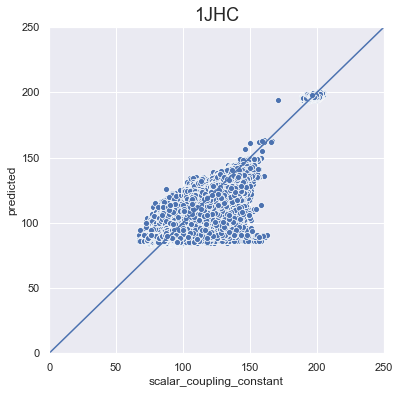

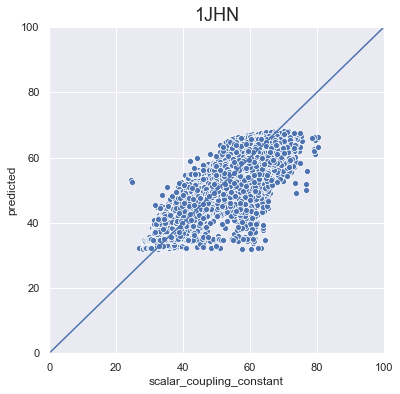

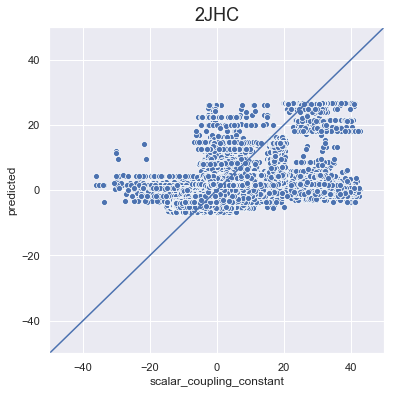

In [30]:
def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)


In [ ]:
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)